
# IST664/CIS668 - Homework 5 Template


Most of this code has been borrowed from Lab 11. If you run into any problems, compare the code to what you used for the lab. 

Use this template to organize your code for Homework 5. Put your name and the names of your collaborators (if any) here:

Your name: Shubham Sharma

Your collaborators: ________________________________


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.8.0'

## Read in the files you will need from manythings.org

This code uses Italian-to-English and English-to-Spanish files.

In [3]:
!curl -O http://www.manythings.org/anki/spa-eng.zip
!unzip -o spa-eng.zip
# I have used -o argument with unzip to overwrite the file every time I run this code. 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5199k  100 5199k    0     0  2256k      0  0:00:02  0:00:02 --:--:-- 2255k
Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


In [4]:
data_path = "spa.txt" # Change this to match the file you unzipped
num_samples = 50000 # Reduce this, but no lower than 500

## Prepare the data for the first file

In [5]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

for line in lines[: min(num_samples, (len(lines) - 1) )]:
    target_text, input_text, _ = line.split("\t")
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

len(input_texts), len(target_texts)

(50000, 50000)

In [6]:
# Review the contents of the file
[ (i, t) for i, t in enumerate(zip(input_texts[:15], target_texts[:15]))]

[(0, ('Ve.', '\tGo.\n')),
 (1, ('Vete.', '\tGo.\n')),
 (2, ('Vaya.', '\tGo.\n')),
 (3, ('Váyase.', '\tGo.\n')),
 (4, ('Hola.', '\tHi.\n')),
 (5, ('¡Corre!', '\tRun!\n')),
 (6, ('¡Corran!', '\tRun!\n')),
 (7, ('¡Corra!', '\tRun!\n')),
 (8, ('¡Corred!', '\tRun!\n')),
 (9, ('Corred.', '\tRun.\n')),
 (10, ('¿Quién?', '\tWho?\n')),
 (11, ('¡Órale!', '\tWow!\n')),
 (12, ('¡Inclínate!', '\tDuck!\n')),
 (13, ('¡Fuego!', '\tFire!\n')),
 (14, ('¡Incendio!', '\tFire!\n'))]

In [7]:
# Task 1: Extract and save the list of Spanish phrases from the file.
# This will be used in Task 5 to create the new phrase pair data. 

spanish_reference_vector = input_texts
spanish_reference_vector[:10]

['Ve.',
 'Vete.',
 'Vaya.',
 'Váyase.',
 'Hola.',
 '¡Corre!',
 '¡Corran!',
 '¡Corra!',
 '¡Corred!',
 'Corred.']

In [8]:
# Task 1: Extract and save the list of English phrases from the file.
# This will be used in Task 4 as input to the trained model. Store this
# in english_reference_vector

english_reference_vector = []
for text in target_texts:
  text = text.strip('\n')
  text = text.strip('\t')
  english_reference_vector.append(text)

english_reference_vector[:10]

['Go.', 'Go.', 'Go.', 'Go.', 'Hi.', 'Run!', 'Run!', 'Run!', 'Run!', 'Run.']

## Create a translation model from English to Italian

Make sure to change this heading to reflect the languages you are actually using. 

The first step right below is to download the phrase pair file.

In [9]:
# We have previously used wget for this task, but curl is quite similar.
# curl supports more protocols, but here we are simply using it to get
# a file from the web with https.
!curl -O http://www.manythings.org/anki/ita-eng.zip
!unzip -o ita-eng.zip
# If you run this more than once, you will be asked if you want to replace
# the first copy of the file(s).

data_path = "ita.txt" # Path to the data txt file on disk.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7576k  100 7576k    0     0   157M      0 --:--:-- --:--:-- --:--:--  160M
Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [10]:
# Example hyperparameters to use for training the model: Tweak to improve
# model performance.

batch_size = 32  # Batch size for training.
epochs = 10  # Number of epochs to train for. We'll raise this later.
latent_dim = 64  # Latent dimensionality of the thoguht vector encoding space.

# The Italian-English file contains about 353,281 phrase pairs.
# I am taking 100,000 samples from that to train.
num_samples = 50000

# Prepare the data by reading from the file

In [11]:
# Read the data from the file, line by line
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

# The *with* statement is a handy way of managing file I/O. It ensures that
# the file gets closed once we are done with it.
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

len(input_texts), len(target_texts) # These should match:
# The length of each should match the num_samples configuration option above.

(50000, 50000)

In [12]:
# There are 82944 unique english phrases and there are 93450 unique Italian phrases in our 100,000 samples. 
len(set(input_texts)), len(set(target_texts))

(18576, 45254)

In [13]:
# SHow some examples. Input texts contain "English" texts and target text contains "Italian" texts. We will use these to train our model. 
[ (i, t) for i, t in enumerate(zip(input_texts[:15], target_texts[:15]))]

[(0, ('Hi.', '\tCiao!\n')),
 (1, ('Hi.', '\tCiao.\n')),
 (2, ('Run!', '\tCorri!\n')),
 (3, ('Run!', '\tCorra!\n')),
 (4, ('Run!', '\tCorrete!\n')),
 (5, ('Who?', '\tChi?\n')),
 (6, ('Wow!', '\tWow!\n')),
 (7, ('Duck!', '\tAmore!\n')),
 (8, ('Duck!', '\tTesoro!\n')),
 (9, ('Duck!', '\tImmergiti!\n')),
 (10, ('Duck!', '\tSi immerga!\n')),
 (11, ('Duck!', '\tImmergetevi!\n')),
 (12, ('Duck!', '\tTuffati!\n')),
 (13, ('Duck!', '\tSi tuffi!\n')),
 (14, ('Duck!', '\tTuffatevi!\n'))]

## Task 3

Create an English to Italian sequence-to-sequence model using the same techniques that were demonstrated in Lab 11. Your training data for this model is the English to Italian phrase pairs you just parsed. Make sure that you modify this documentation to reflect the languages you actually used.

In [14]:
# Here's the code from the lab: You must modify this code to ensure that 
# the characters from english_reference_vector are included in the input
# tokens.
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

# These need not match
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)

Number of unique input tokens: 72
Number of unique output tokens: 81


In this next block, you must ensure that your maximum message length for the encoder portion of the second model is large enough to handle the longest message from english_reference_vector (if it happens to be longer than the max length phrase in the E2G phrase-pair file). 

In [15]:
# These are the "message lengths" calibrated in the number of characters.
# Because we are doing a character-level model these values define how far
# the encoder LSTM and the decoder LSTM (respectively) need to be "unrolled"
# in order to do the training. 
#
# Also remember that shorter sequences will need to be padded.
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Max sequence length for inputs: 18
Max sequence length for outputs: 104


In [16]:
# Next we will vectorize all of the input and target messages

# First, make Python dictionaries for the input and target messages
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

# Remember that the seq2seq data is actually a 3-tuple. The encoder takes 
# input messages as input but creates no output except for the hidden state.
# The decoder has both inputs and targets. These three lines fill vectors
# with zeroes to initialize them.

# The encoder inputs - will hold character sequences for short English phrases
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")

# The decoder inputs - will hold character sequences for short Spanishh phrases
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

# Same size numpy array for the decoder targets
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype = "float32")

In [17]:
# Now fill the vectors

# Iterate over all of our phrase pairs
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    # Iterate over all of the characters in the input phrase
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0

    # This adds padding with spaces
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

    # Iterate over all of the characters in the target phrase. Here we are
    # filling two vectors 
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    
    # This adds padding with spaces
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [18]:
len(encoder_input_data), len(decoder_input_data), len(decoder_target_data)

(50000, 50000, 50000)

Build the model

In [19]:
# 1. Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))

# 2. Use a LSTM layer to process the input vectors. After today's lecture
# you should know what return_state does.
encoder = keras.layers.LSTM(latent_dim, return_state=True)

# 3. Save the output from the encoder, but see step 4. Note the use of 
# the functional programming interface here. For deep learning models that
# are not simple seqiential layers, this interface provides a stratightforward
# way of connecting one element of a model to the element that it should 
# feed into.
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# 4. We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [20]:
# Set up the decoder, using `encoder_states` as initial state.

# This takes the target tokens as the input.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# The LSTM later has the same internal dimensionality as for the encoder.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)

# Save the decoder output: Note that this uses decoder_inputs
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Dense with softmax allows us to predict categorical output (our list of Spanish characters)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")

# Output layer
decoder_outputs = decoder_dense(decoder_outputs)

# Define the overall model. This binds the encoder and decoder and will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [21]:
# We use categorical_crossentropy because our prediction is multinomial: we
# are trying to predict which is the most likely character for the next time step.
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 72)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 81)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 64),         35072       ['input_1[0][0]']                
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                              

## Train the model

In [22]:
# With GPU on and 15,000 instances, each epoch after the first one should take
# about four seconds, for a total training time of under two minutes.
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=16,
    epochs=100,
    validation_split=0.2
)

# You should be looking for a val_categorical_accuracy well in excess of 0.90.

Epoch 1/100
2500/2500 [==============================] - 30s 10ms/step - loss: 0.3879 - categorical_accuracy: 0.8894 - val_loss: 0.3599 - val_categorical_accuracy: 0.8897
Epoch 2/100
2500/2500 [==============================] - 22s 9ms/step - loss: 0.2796 - categorical_accuracy: 0.9137 - val_loss: 0.3159 - val_categorical_accuracy: 0.9028
Epoch 3/100
2500/2500 [==============================] - 22s 9ms/step - loss: 0.2506 - categorical_accuracy: 0.9221 - val_loss: 0.2929 - val_categorical_accuracy: 0.9094
Epoch 4/100
2500/2500 [==============================] - 22s 9ms/step - loss: 0.2323 - categorical_accuracy: 0.9279 - val_loss: 0.2783 - val_categorical_accuracy: 0.9141
Epoch 5/100
2500/2500 [==============================] - 22s 9ms/step - loss: 0.2194 - categorical_accuracy: 0.9321 - val_loss: 0.2679 - val_categorical_accuracy: 0.9175
Epoch 6/100
2500/2500 [==============================] - 22s 9ms/step - loss: 0.2099 - categorical_accuracy: 0.9350 - val_loss: 0.2608 - val_categori

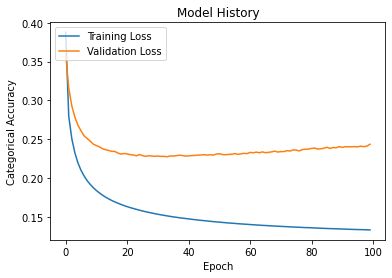

In [23]:
# Graphing code fragment modified from Rahul Verma on Stackoverflow
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model History')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

# Add a comment about training success

Add a comment here that describes what you see in the model history graph. Is it evident that you have reached the point in the training where not much additional improvement can be achieved? How do you know? Is the categorical accuracy sufficient?

#### Notes:
- I trained the model with 50000 samples from the phrase-pairs data with epochs=100 and batch_size=32. I got ~93% val_categorical accuracy. I was curious to train with all samples and bought a monthly subscription of Colab Pro but even 27GB of RAM was not enough to load the entire data. 

- To get more accuracy, we can increase the sample size but we would need a lot more RAM. We can choose a different validation split or we can add more LSTM layers. I reduced the batch size from 32 to 16 and got a similar accuracy of ~93%. 

- In the above plot, we can see the validation loss is constant for epochs between 20 and 40 and then, started to increase gradually. After 40 epochs, we enter the area of overfitting the model when the training loss decreases but the validation loss increases. 

- I believe if we include all the samples, we would get a substantial improvement in accuracy because when I tried with just 5000 samples, I got an accuracy of ~84%.

## Task 4: Use the trained model for inference

The basic inference functions from Lab 11 are included here. You should run english_reference_vector through the translator to create a list of Italian translations. These Italian translations will then match the meaning and sequence of the Italian phrases from the first data set.

Note: Add a code timer to the appropriate code to find out how long it takes to run inference. 

In [24]:
# Construct the encoder and decoder
# Define sampling models

encoder_inputs = model.input[0]  # Encoder input layer
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # First LSTM

# This is the "thought vector" the hidden state that is used to start the decoder
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # This is the second/decoder input layer
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = model.layers[3] # Second LSTM 

decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model.layers[4] # Dense output layer

decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [25]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [26]:
# Create a function to decode the sequences. This takes a one-hot encoded 
# input sequence as the input. It runs the encoder model with that input to
# generate the "thought vector." The thought vector is fed to the decoder
# model and a \t is issued to the decoder to start producing a sequence.

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ""
    
    # Always a little risky to use a while loop, but we don't know what 
    # length of sentence the decoder will issue - that's pretty much the 
    # whole point of a sequence-to-sequence model, right?
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token: Find the index of the most probable output character
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Use our reversing dictionary to decode the predicted character
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length of a decoder output sequence
        # or find that the decoder has issued a stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))

        # This one-hot encodes the current character to use as input for the next iteration
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    
    return decoded_sentence


In [27]:
def translate(text_2):
  text_2 = text_2.replace("\n","")
  if len(text_2) <= max_encoder_seq_length:
    # Fill up a single one-hot encodign vector with zeroes
    my_input_data =  np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype="float32")

    # Iterate over all of the characters in the input phrase
    for t, char in enumerate(text_2):
      my_input_data[0, t, input_token_index[char]] = 1.0

    # This adds padding with spaces
    my_input_data[0, t + 1 :, input_token_index[" "]] = 1.0
    translated_sentence = decode_sequence(my_input_data)
    print (text_2, " ", translated_sentence)
    return translated_sentence

  else:
    print("Input phrase is longer than the maximum encoder sequence length.")


Make sure to report the inference time. It will be best to specify the number of seconds it takes to translate 100 phrases.

In [28]:
translate("You look good toda")

You look good toda   Sembrava arrabbiato.



'Sembrava arrabbiato.\n'

# Task 5: Join the original Spanish phrases with the new Spanish translations

Make sure to save the resulting phrase pairs as a CSV file. This should be submitted along with your notebook.

Important - Add a new text block at the end of your notebook and answer these questions: What is the final configuration of hyperparameters (batch size, epochs, etc.) that you used to achieve satisfactory performance? Would a more complex or larger model perform better, or have you reached the limit of what the training data can support? What is the main stumbling block to improved performance of your translation model? How could you use this technique for tasks other than translation? (Hint, where else are phrase pairs important?)

In [29]:
import time
italian_translation = []

# 18 is the max sequence length for inputs and that is the maximum the encoder LSTM can be unrolled. Therefore, I need to remove all sentences in english_reference_vector 
# whose length is more than max_encoder_seq_length.

modified_english_vector = [x for x, y in zip(english_reference_vector, list(np.array([len(text) for text in english_reference_vector]) < max_encoder_seq_length)) if y == True]
for i in modified_english_vector:
  italian_translation.append(translate(i))

Streaming output truncated to the last 5000 lines.
I found the keys.   Io ho fatto del mio cappello.

I found your cap.   Ti ho trovato un po' di te.

I gave up my job.   Ho dato un po' di tiparta.

I get that a lot.   Mi sono sentito a casa.

I get up at 6:30.   Sono incontati tutto quello conto.

I get up at 7:00.   Io mi sentii la mia birra.

I get your point.   Sono stato senza una macchina.

I go to the park.   Ho fatto è impegnato.

I got her a doll.   Mi sono sentito una macchina.

I got hurt today.   Mi sono sentito al casa.

I grabbed a book.   Io prendo un altro adesso.

I guess we could.   Mi mancano i casa.

I had a huge dog.   Io odio la sua canda.

I had three dogs.   Io odiociamo questo.

I had three dogs.   Io odiociamo questo.

I had to be sure.   Io odio le solletta.

I hate chemistry.   Odio il partetto.

I hate chocolate.   Odio il mio cappello.

I hate computers.   Odio le spariche.

I hate computers.   Odio le spariche.

I hate hypocrisy.   Odio questa scusa.

I h

In [34]:
import pandas as pd

df = pd.DataFrame(list(zip(spanish_reference_vector, italian_translation)),
               columns =['Spanish', 'Italian'])
from google.colab import drive
drive.mount('drive')

df.to_csv('/content/drive/My Drive/translations.csv', encoding='utf-8', index=False)

Mounted at drive


# What I did:

- On the Anki website, there are a few language pairs available. If I want to translate Spanish to Italian, I can use two phrase pairs - Spanish to English and English to Italian. 

- Using Encoder-Decoder architecture, I did character level sequence to sequence training trying to predict the next character. 

- Traditional RNN can't be used for this process as they suffer from a short-term memory. LSTMs and GRUs fix that problem. I have used LSTM to train the model with 100 epochs and batch size of 16. I got a validation accuracy of ~93%.

- While translating, we need to remember the maximum sequence length for the encoder and need to pass only those phrases for translation which have less characters than the maximum length for encoder. Because, we are asking encoder to roll the LSTMs that many time. 

- **What is the final configuration of hyperparameters (batch size, epochs, etc.) that you used to achieve satisfactory performance?  Would a more complex or larger model perform better, or have you reached the limit of what the training data can support?**

As I mentioned earlier, I tried with 100 and 50 epochs and batch size of 16 and 32. In all cases, I got accuracy around ~93%. The original phrase pair file contains around 138k samples but I used only 50k samples due to RAM limitations. I believe 93% accuracy in machine translation is not good and a more complex model can perform better by making more LSTM layers or by training on the entire database. With our hyperparameters and limited RAM, we reached a state where we overfitting the model if we used more than 50 epochs.

- **What is the main stumbling block to improved performance of your translation model? How could you use this technique for tasks other than translation? (Hint, where else are phrase pairs important?)**

I think main stumbling block would be not using the entire phrase pair data. First we downsampled the data while building the model and then we again downsampled while translating. Requirement of high RAM demands us to do this. Another stumbling block could be that we are using character level modeling. Performance can be improved if we use word-level modeling. We can use sequence to sequence technique in question answering, speech recognition. 